# Fig. 5
- In this experiment, we ablated the axons of habenula neurons unilaterally
- Before and after the ablation, we repeated the experiment where the sun-and-bars scene was presented
- This notebook will generate panels for **Fig. 5** as well as **Extended Data Fig. 1, 9, 10**

In [1]:
# import packages
from utility import *
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.stats import binned_statistic, kstest, uniform
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
import json
import colorcet as cc
from tqdm import tqdm
from sklearn.linear_model import Ridge

C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# configure matplotlib
config_rcparams()

In [55]:
# parameters
R2_thresh = 0.15  # for sinusoidal fit
flash_thresh = 0.1 # for rejecting flash responsive cells
n_heading_bin = 8 # binning HD cells
n_offset_bin = 16 # binning scene-bump offset
n_bootstrap = 1000 # #bootstrap shuffles
hw = 10 # half width of time trace snippets to run regression on, in seconds

# quality control
empty_bin_thresh = 5
corr_thresh = 0.4 # pre-post ablation experiment need to retain the correlation structure (to make sure we are looking at the same cells)
kappa_thresh = 0.5 # we reject fish with low kappa to begin with

cnames = ('smooth','jump')

In [28]:
# Fet a list of fish
base_path = Path('../data/main05')
fish_list = base_path.glob('202*f*')

rec_list = []
for fish in fish_list:
    prepath  = fish / 'pre'
    postpath = fish / 'post'
    rec_list.append({'fish': fish, 'pre': prepath, 'post': postpath})

# Analysis
## Data extraction and ROI selection

In [29]:
data = []
for paths in tqdm(rec_list):
    
    ### ON ABLATION ###
    # First, figure out the ablation side
    with open(paths['fish'] / 'habenula_summary.json', 'r') as f:
        habenula_summary = json.load(f)
        
    # Decide the inversion status by comparing the number of visual ROIs
    # This is hacky, but there are 1 fish with nl==nr and 2 fish with nl=1==nr, 
    # all of which I believe are situs solitus, based on the morphology
    is_inverted = habenula_summary['nr'] > habenula_summary['nl']+2 
    
    # Load ablation side
    with open(paths['fish'] / 'ablation_side.txt', 'r') as f:
        ablation_side = f.read() # 0 for L, 1 for R
    
    # Visual side ablated group if True, Control if False
    visual_side_ablated = is_inverted == int(ablation_side)
    
    ### DATA LOADING ###
    pre_roi_path  = list(paths['pre'].glob('paired_manual_rois*'))[0]
    post_roi_path = paths['post']  / pre_roi_path.name
    
    traces_pre = np.load(pre_roi_path, allow_pickle=True)[()]['traces']
    traces_post = np.load(post_roi_path, allow_pickle=True)[()]['traces']
    n_roi = traces_pre.shape[0]
    
    t_pre  = fl.load(paths['pre'] / 'time.h5')['t']
    t_post = fl.load(paths['post'] / 'time.h5')['t']

    exp_pre = EmbeddedExperiment(paths['pre']  / "behavior")
    exp_post = EmbeddedExperiment(paths['post'] / "behavior")
    
    ### PREPROCESSING ###
    slog_pre  = exp_pre['stimulus']['log'] # list of dict specifying epochs
    slog_post = exp_post['stimulus']['log']

    t_s_pre  = exp_pre.stimulus_log['t'].to_numpy() # stimulus timestamps
    t_s_post = exp_post.stimulus_log['t'].to_numpy()

    theta_pre  = exp_pre.stimulus_log['cl2D_theta'].to_numpy() # scene orientation
    theta_post = exp_post.stimulus_log['cl2D_theta'].to_numpy()

    theta_i_pre  = downsample_traces(t_s_pre, theta_pre, t_pre) # downsample to imaging resolution
    theta_i_post = downsample_traces(t_s_post, theta_post, t_post)

    norm_traces_pre  = (traces_pre - np.mean(traces_pre, axis=1)[:, None]) / np.std(traces_pre, axis=1)[:, None]
    norm_traces_post = (traces_post - np.mean(traces_post, axis=1)[:, None]) / np.std(traces_post, axis=1)[:, None]

    smoothed_traces_pre = convolve2d(norm_traces_pre, np.ones((1,5))/5, mode='same')
    smoothed_traces_post = convolve2d(norm_traces_post, np.ones((1,5))/5, mode='same')
    
    gtheta_pre  = exp_pre.stimulus_log['cl2D_goal_theta'].to_numpy() # split theta into exafferent and reafferent components
    gtheta_post = exp_post.stimulus_log['cl2D_goal_theta'].to_numpy()
    
    ftheta_pre  = exp_pre.stimulus_log['cl2D_fish_theta'].to_numpy()  * exp_pre.stimulus_log['cl2D_start_theta_update'].to_numpy()
    ftheta_post = exp_post.stimulus_log['cl2D_fish_theta'].to_numpy() * exp_post.stimulus_log['cl2D_start_theta_update'].to_numpy()

    ftheta_pre[np.isnan(ftheta_pre)] = 0
    ftheta_post[np.isnan(ftheta_post)] = 0

    cumftheta_i_pre = downsample_traces(t_s_pre, np.cumsum(ftheta_pre), t_pre)
    cumftheta_i_post = downsample_traces(t_s_post, np.cumsum(ftheta_post), t_post)

    extheta_i_pre  = downsample_traces(t_s_pre,  gtheta_pre+np.cumsum(ftheta_pre), t_pre)
    extheta_i_post = downsample_traces(t_s_post, gtheta_post+np.cumsum(ftheta_post), t_post)
    
    ### ROI SELECTION (on pre data) ###
    # Flash responsive cell rejection
    flash_duration = slog_pre[1]['duration']*2
    flash_t_start = [epoch['t_start'] for epoch in slog_pre[1:-2:2]] # first epoch is wait, last two epochs are sun-and-bars  
    flash_corr = calc_snip_correlation(norm_traces_pre, t_pre, flash_t_start, flash_duration)
    
    # Sinusoidal regression
    training_set = (np.isnan(theta_i_pre)==False) * split_time(t_pre, slog_pre[-2]['t_start'], slog_pre[-2]['duration'], is_train=True)
    fit_param, _, R2 = fit_transform_sinusoid(smoothed_traces_pre[:, training_set], theta_i_pre[training_set])
    
    # selection
    good_fit = (R2 > R2_thresh) * (flash_corr < flash_thresh)
    gf_ind = np.where(good_fit)[0]
    preferred_theta = fit_param[gf_ind, 1]
    selected_traces_pre  = smoothed_traces_pre[gf_ind, :]
    selected_traces_post = smoothed_traces_post[gf_ind, :]
    
    ### NEURAL HEADING ESTIMATE CALCULATION ###
    pva_theta_pre, pva_length_pre, binned_traces_pre, _, _ = calc_binned_pva(selected_traces_pre, preferred_theta)
    roi_remained = np.isnan(np.sum(selected_traces_post, axis=1))==False  # Some ROIs are missing in post recordings, and this will mess up binning so we remove it first
    pva_theta_post, pva_length_post, binned_traces_post, _, _ = calc_binned_pva(selected_traces_post[roi_remained, :], preferred_theta[roi_remained])
 
    ### DATA LOGGING ###
    Dpre = {'t': t_pre, 'theta': theta_i_pre, 'cumftheta': cumftheta_i_pre, 'extheta': extheta_i_pre,
            'traces': selected_traces_pre, 'binned_traces': binned_traces_pre, 'pva_theta': pva_theta_pre, 'pva_length': pva_length_pre, 'slog': slog_pre}
    Dpost = {'t': t_post, 'theta': theta_i_post, 'cumftheta': cumftheta_i_post, 'extheta': extheta_i_post,
             'traces': selected_traces_post, 'binned_traces': binned_traces_post, 'pva_theta': pva_theta_post, 'pva_length': pva_length_post, 'slog': slog_post}
    data.append({'pre': Dpre, 'post': Dpost, 'preferred_theta': preferred_theta, 'n_roi': n_roi, 'visual_side_ablated': visual_side_ablated, 'fish': paths['fish']})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:11<00:00,  3.30it/s]


## Additional preprocessing
- Calculate offset histogram and fit von Mises distribution for each epoch for each recording
- Calculate correlation matrix among ROIs in each recording, and compare the two

In [30]:
# prepare bin edges for histogram calculations
offset_bin_edges = np.linspace(-np.pi, np.pi, n_offset_bin+1)
offset_bin_center = (offset_bin_edges[:-1] + offset_bin_edges[1:])/2

In [31]:
kappas = [[], []]
c_prepost = [[], []]
for i, D in enumerate(data):
    for rec in ('pre', 'post'):
        
        # prepare time
        t = D[rec]['t']
        bump_scene_offset = angular_diff(D[rec]['theta'], D[rec]['pva_theta'])
        
        if rec=='pre':
            is_smooth = split_time(t,  D[rec]['slog'][-2]['t_start'], D[rec]['slog'][-2]['duration'], is_train=False)
        else:
            is_smooth = (t > D[rec]['slog'][-2]['t_start'] ) * (t < D[rec]['slog'][-1]['t_start'])
        is_jump = t > D[rec]['slog'][-1]['t_start']

        # calculate histograms
        hist_s = np.histogram(bump_scene_offset[is_smooth],   bins=offset_bin_edges, density=True)[0]
        hist_j = np.histogram(bump_scene_offset[is_jump],   bins=offset_bin_edges, density=True)[0]

        # do the fitting
        fit_s  = curve_fit(von_Mises, offset_bin_center, hist_s, bounds=([-np.pi,0], [np.pi,np.inf]))[0]
        fit_j  = curve_fit(von_Mises, offset_bin_center, hist_j, bounds=([-np.pi,0], [np.pi,np.inf]))[0]
        
        # register histograms
        data[i][rec]['offset_hists'] = (hist_s, hist_j)
        data[i][rec]['hist_fits'] = (fit_s, fit_j)
    
    try: # in some cases this errors, because not enough ROIs etc. We don't care these fish so just throw exception and carry on
        # calculate pairwise correlation and their correlation
        C_pre  = np.corrcoef(D['pre']['traces'])
        C_post = np.corrcoef(D['post']['traces'])
        unique_corr_ind = np.triu(np.ones(C_pre.shape[0], dtype=bool),1)
        corr_of_corr = np.corrcoef(C_pre[unique_corr_ind], C_post[unique_corr_ind])[1,0]

        # register
        data[i]['pre']['C'] = C_pre
        data[i]['post']['C'] = C_post
        data[i]['r_prepost'] = corr_of_corr
    except:
        data[i]['r_prepost'] = np.nan
        continue

C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [32]:
## Pull out everything as 1d array for the ease of visualization

# correlation of correlation among cells across recordings
r_prepost = np.asarray([D['r_prepost'] for D in data])

# reject fish with too many empty bins
n_empty_bins = np.asarray([np.sum(np.isnan(D['pre']['binned_traces'][:, 0])) for D in data])

# boolean for the treatment groups
vsa = np.asarray([D['visual_side_ablated'] for D in data]).astype(int)

# von Mises fit
fit_param = np.asarray([[D[rec]['hist_fits'] for rec in ('pre', 'post')] for D in data]) # nested in the order of fish > pre/post > smooth/jump > mu/kappa

# ratio of pre-post kappa, which is the ultimate measure of the 
kappa_ratio = fit_param[:, 1, :, 1]/fit_param[:, 0, :, 1]

# Apply various thresholds for quality control
good_rec = (r_prepost > corr_thresh) * (n_empty_bins < empty_bin_thresh) 
good_pre_kappa = fit_param[:, 0, :, 1] > kappa_thresh

# Panels
## Fig. 5c, d (Example fish with visual side ablation)

In [33]:
# pick an example fish
fid = 12
D = data[fid]

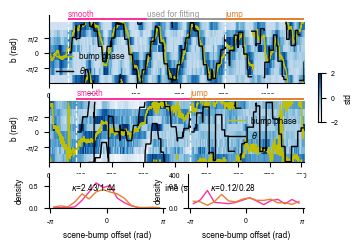

In [35]:
# time trace + histogram for pre/post

fig, ax = plt.subplot_mosaic([['pre','pre'],['post','post'],['hpre','hpost']], figsize=(3.3, 2.5), height_ratios=(2,2,1))

# loop through recordings
for i, rec in enumerate(('pre', 'post')):
    
    t = D[rec]['t']
    trace = D[rec]['binned_traces']
    theta = D[rec]['theta']
    bump = D[rec]['pva_theta']
    
    # neural trace
    im = ax[rec].imshow(trace[::-1, :], aspect='auto', interpolation='nearest', vmax=2, vmin=-2, extent=(0, max(t), -np.pi, np.pi), cmap='Blues')
    
    # bump & theta
    ax[rec].plot(t, wrapped(bump), 'y-', linewidth=1, label='bump phase')
    ax[rec].plot(t, wrapped(theta), 'k-', linewidth=1, label=r'$\theta$')
    ax[rec].legend()
    
    for j in range(-1,-3,-1):
        ax[rec].plot((D[rec]['slog'][j]['t_start'], D[rec]['slog'][j]['t_start']),(-np.pi,np.pi),'w--')
    
    # annotate epochs - only pre recording has the "HD cell identification" epoch
    key_t = [D[rec]['slog'][-2]['t_start'], D[rec]['slog'][-2]['t_start'] + D[rec]['slog'][-2]['duration']/2, D[rec]['slog'][-1]['t_start'], max(t)]
    cnames = ['smooth','used for fitting','jump']
    this_col = list(color_getter([0, 1, 2]))
    if rec=='post':
        key_t.pop(1)
        cnames.pop(1)
        this_col.pop(1)
    
    for k in range(len(key_t)-1):
        ax[rec].fill_between((key_t[k], key_t[k+1]), (np.pi+0.2, np.pi+0.2), (np.pi+0.4, np.pi+0.4), facecolor=this_col[k])
        ax[rec].text(key_t[k], np.pi+0.6, cnames[k], color=this_col[k])
    ax[rec].set_xlabel('time (s)')
    ax[rec].set_ylabel('b (rad)')
    ax[rec].set_yticks([-np.pi/2, 0, np.pi/2])
    ax[rec].set_yticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))

    # scene-bump offset histogram
    for j in range(2):
        ax['h'+rec].plot(offset_bin_center, D[rec]['offset_hists'][j], color=color_getter(j*2), label=cnames[j])
    ax['h'+rec].text(-2, 0.4, '$\kappa$={:0.2f}/{:0.2f}'.format(D[rec]['hist_fits'][0][1], D[rec]['hist_fits'][1][1]))
    ax['h'+rec].set_xlabel('scene-bump offset (rad)')
    ax['h'+rec].set_ylim(0,0.8)
    ax['h'+rec].set_ylabel('density')
    ax['h'+rec].set_xticks([-np.pi, 0, np.pi])
    ax['h'+rec].set_xticklabels((r'-$\pi$', '0', r'$\pi$'))
    toggle_spines(ax[rec],0,1,0,1)
    toggle_spines(ax['h'+rec],0,1,0,1)

cbax = fig.add_axes([0.9,0.3, 0.05, 0.5])
cbax.axis('off')
cb = plt.colorbar(im, ax=cbax, shrink=1)
cb.set_label('std')

plt.savefig('../svg/main05_cd.svg')
plt.show()

## Fig. 5e, f (Population data of $\kappa$ in each epoch / recording, as well as ratios)
- Show pre-post kappa as a scatter plot
- Do ratio bar graphs

smooth N = 13 / 15 (visual/ctrl.)
jump N = 12 / 13 (visual/ctrl.)


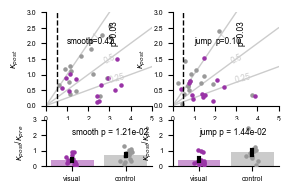

In [38]:
# nested in the order of fish > pre/post > smooth/jump > mu/kappa

fig, ax = plt.subplots(2, 2, figsize=(3,2), height_ratios=(2, 1))

epochs = ('smooth', 'jump')
groups = ('visual', 'control')

for i, epoch in enumerate(epochs):
    
    # plot kappa pre vs post, separately for smooth/jump, color coded by ablation side
    for j, group  in enumerate(groups):
        this_group = (vsa==j) * good_rec
        # kappa pre vs. kappa post
        ax[0, i].scatter(fit_param[this_group, 0, i, 1], fit_param[this_group, 1, i, 1], s=5, color=color_getter(1+j*7))
        
    # ratio guide line
    for j in range(3):
        beta = 2**(-j)
        ax[0, i].plot((0,5),(0,5*beta), zorder=-3, color=(0.8,0.8,0.8))
        label_x = np.sqrt(3**2/(1+beta**2)) 
        ax[0, i].text(label_x, beta*label_x, str(beta), color=(0.8,0.8,0.8), rotation=np.arctan(beta)/np.pi*180)
        
    # by-axis p values
    for k, recording in enumerate(('pre','post')):
        p = ranksums(*[fit_param[(vsa==j) * good_rec * good_pre_kappa[:,i], k, i, 1] for j in range(2)])
        ax[0, i].text(2+k, 2, 'p={:0.2f}'.format(p[1]), rotation=k*90)
    
    # shared pretification for scatter plots
    ax[0, i].set_xlim([0,5])
    ax[0, i].set_ylim([0,3])
    ax[0, i].plot((kappa_thresh, kappa_thresh), (0, 3), 'k--')
    ax[0, i].text(1, 2, epoch)
    ax[0, i].set_xlabel('$\kappa_{pre}$')
    ax[0, i].set_ylabel('$\kappa_{post}$')
    
    # bar plots of kappa ratio
    ratio_p = scatter_bar((kappa_ratio[(vsa==1)*good_rec*good_pre_kappa[:,i],i], kappa_ratio[(vsa==0)*good_rec*good_pre_kappa[:,i],i]),
                           ax=ax[1, i], s=5, color=color_getter((8,1)), condnames=groups)
    print(epoch, 'N = {} / {} (visual/ctrl.)'.format(*[np.sum((vsa==k)*good_rec*good_pre_kappa[:,i]) for k in (1,0)]))
    ax[1, i].set_ylabel(r'$\kappa_{post}$/$\kappa_{pre}$')
    ax[1, i].set_ylim([0, 3])
    ax[1, i].text(0, 2, epoch+' p = {:0.2e}'.format(ratio_p[0,1]))
    
    toggle_spines(ax[0, i], 0, 1, 0, 1)
    toggle_spines(ax[1, i], 0, 1, 0, 1)
    
plt.savefig('../svg/main05_ef.svg')
plt.show()

## Extended Data Fig. 9d-f (Correlation structure of the HD cell activity across recordings)

In [39]:
# pick an example fish
fid = 12
D = data[fid]

In [40]:
b = D['preferred_theta']
C0 = D['pre']['C'][np.argsort(b), :][:, np.argsort(b)]
C1 = D['post']['C'][np.argsort(b), :][:, np.argsort(b)]

# combine the correlation matrix across diagonal
combC = C0 * np.tril(np.ones(C0.shape),-1) + C1 * np.triu(np.ones(C0.shape),1)

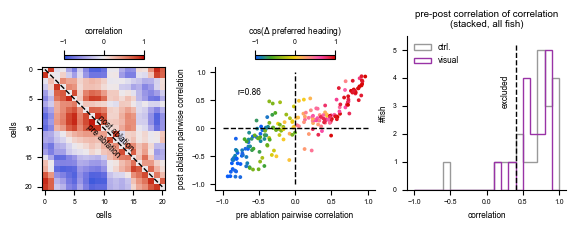

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(7,2))

# correlation map pre & post (panel d)
ncell = C0.shape[0]
im = ax[0].imshow(combC, vmin=-1, vmax=1, cmap=cc.cm.CET_D1)
cb = plt.colorbar(im, location='top', shrink=0.5)
cb.set_label('correlation')
ax[0].set_ylabel('cells')
ax[0].set_xlabel('cells')
ax[0].plot((0,ncell-1),(0,ncell-1),'k--')
ax[0].text(10,15 , 'pre ablation', rotation=-45, horizontalalignment='center')
ax[0].text(12,14 , 'post ablation', rotation=-45, horizontalalignment='center')


# correlation pre vs post (panel e)
bdiff = np.cos(angular_diff(b[None,np.argsort(b)],b[np.argsort(b),None]))
sc = ax[1].scatter(C0[np.triu(np.ones(C0.shape),1)==1], C1[np.triu(np.ones(C0.shape),1)==1], s=3,
              c=bdiff[np.triu(np.ones(C0.shape),1)==1], vmax=1, vmin=-1, cmap=cc.cm.CET_R3)
cb2 = plt.colorbar(sc, location='top', shrink=0.5)
cb2.set_label('cos($\Delta$ preferred heading)')
ax[1].text(-0.8, 0.6, 'r={:0.2f}'.format(r_prepost[fid]))

ax[1].plot([-1,1],[0,0],'k--')
ax[1].plot([0,0],[-1,1],'k--')
ax[1].set_xlabel('pre ablation pairwise correlation')
ax[1].set_ylabel('post ablation pairwise correlation')
toggle_spines(ax[1],0,1,0,1)


# histogram of correlation of correlation (panel f)
ax[2].hist((r_prepost[vsa==1], r_prepost[vsa==0]), color=(color_getter(8), color_getter(1)) , histtype='step', bins=np.linspace(-1,1,21), label=('visual','ctrl.'))
ax[2].set_title('pre-post correlation of correlation\n(stacked, all fish)')
ax[2].plot([corr_thresh, corr_thresh], [0, ax[2].get_ylim()[1]], 'k--')
ax[2].text(0.2,3,'excluded',rotation=90)
ax[2].set_xlabel('correlation')
ax[2].set_ylabel('#fish')
toggle_spines(ax[2],0,1,0,1)
ax[2].legend()

plt.savefig('../svg/ed09_def.svg')
plt.show()

## Extended Data Fig. 9gh (An example fish in the control group)

In [42]:
fid = 10
D = data[fid]

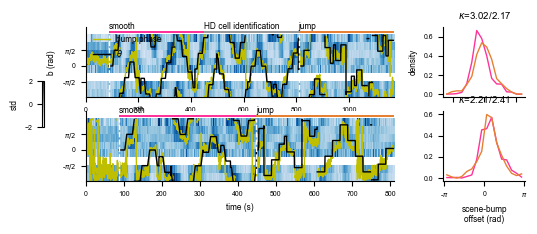

In [45]:
# time trace + histogram for pre/post
fig, ax = plt.subplots(2, 2, figsize=(7,2), width_ratios=(5,1))

for i, rec in enumerate(('pre', 'post')):
    t = D[rec]['t']
    trace = D[rec]['binned_traces']
    theta = D[rec]['theta']
    bump = D[rec]['pva_theta']
    
    # neural trace
    im = ax[i,0].imshow(trace[::-1, :], aspect='auto', interpolation='nearest', vmax=2, vmin=-2, extent=(0, max(t), -np.pi, np.pi), cmap='Blues')
    ax[i,0].plot(t, wrapped(bump), 'y-', linewidth=1, label='bump phase')
    ax[i,0].plot(t, wrapped(theta), 'k-', linewidth=1, label=r'$\theta$')
    ax[0,0].legend()
    ax[i,0].set_yticks([-np.pi/2, 0, np.pi/2])
    ax[i,0].set_yticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))
    
    for j in range(-1,-3,-1):
        ax[i,0].plot((D[rec]['slog'][j]['t_start'], D[rec]['slog'][j]['t_start']),(-np.pi,np.pi),'w--')
    
    # annotation - only pre recording has the "HD cell identification" epoch
    key_t = [D[rec]['slog'][-2]['t_start'], D[rec]['slog'][-2]['t_start'] + D[rec]['slog'][-2]['duration']/2, D[rec]['slog'][-1]['t_start'], max(t)]
    cnames = ['smooth','HD cell identification','jump']
    this_col = this_col = list(color_getter([0, 1, 2]))
    if rec=='post':
        key_t.pop(1)
        cnames.pop(1)
        this_col.pop(1)
    
    for k in range(len(key_t)-1):
        ax[i,0].fill_between((key_t[k], key_t[k+1]), (np.pi+0.2, np.pi+0.2), (np.pi+0.4, np.pi+0.4), facecolor=this_col[k])
        ax[i,0].text(key_t[k], np.pi+0.6, cnames[k])
    
    # histogram
    for j in range(2):
        ax[i,1].plot(offset_bin_center, D[rec]['offset_hists'][j], color=color_getter(j*2), label=cnames[j])
    ax[i,1].set_title('$\kappa$={:0.2f}/{:0.2f}'.format(D[rec]['hist_fits'][0][1], D[rec]['hist_fits'][1][1]))
    
ax[1,0].set_xlabel('time (s)')
ax[0,0].set_ylabel('b (rad)')
ax[0,1].set_xticklabels([])
ax[0,1].set_ylabel('density')
ax[1,1].set_xlabel('scene-bump\noffset (rad)')
ax[1,1].set_xticks([-np.pi, 0, np.pi])
ax[1,1].set_xticklabels((r'-$\pi$', '0', r'$\pi$'))

cb = plt.colorbar(im, ax=ax[:,0], shrink=0.3, location='left')
cb.set_label('std')

for row in ax:
    for axx in row:
        toggle_spines(axx,0,1,0,1)

plt.savefig('../svg/ed09_gh.svg')
plt.show()

## Extended Data Fig. 10a (post visual side recordings with bump movement at scene rotations)

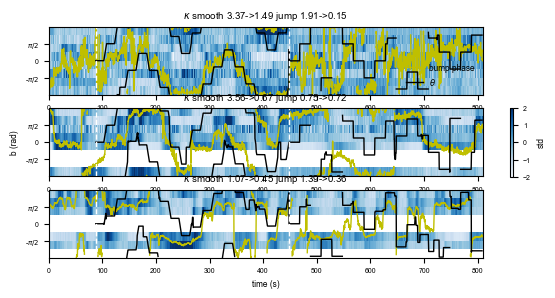

In [46]:
fids = (8,19,29)

# time trace + histogram for pre/post
fig, ax = plt.subplots(len(fids), 1, figsize=(7,1 * len(fids)))

rec = 'post'
for i, fid in enumerate(fids):
    
    D = data[fid]

    t = D[rec]['t']
    trace = D[rec]['binned_traces']
    theta = D[rec]['theta']
    bump = D[rec]['pva_theta']
    
    # neural trace
    im = ax[i].imshow(trace[::-1, :], aspect='auto', interpolation='nearest', vmax=2, vmin=-2, extent=(0, max(t), -np.pi, np.pi), cmap='Blues')

    # bump & theta
    ax[i].plot(t, wrapped(bump), 'y-', label='bump phase')
    ax[i].plot(t, wrapped(theta), 'k-', label=r'$\theta$')

    # annotation
    for j in range(-1,-3,-1):
        ax[i].plot((D[rec]['slog'][j]['t_start'], D[rec]['slog'][j]['t_start']),(-np.pi,np.pi),'w--')
    ax[i].set_title('$\kappa$ smooth {:0.2f}->{:0.2f} jump {:0.2f}->{:0.2f}'.format(fit_param[fid, 0, 0, 1], fit_param[fid, 1, 0, 1], fit_param[fid, 0, 1, 1], fit_param[fid, 1, 1, 1]))
    ax[i].set_yticks([-np.pi/2, 0, np.pi/2])
    ax[i].set_yticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))

# axis management
ax[0].legend()
ax[1].set_ylabel('b (rad)')
ax[-1].set_xlabel('time (s)')
cb = plt.colorbar(im, ax=ax, shrink=0.3)
cb.set_label('std')

plt.savefig('../svg/ed10_a.svg')
plt.show()

## Extended Data Fig. 1g (behavior at scene rotations)

In [47]:
# Cut out snippets of exafferent rotation & cumulative turns

mean_snips = []

# loop through fish
for i, DD in enumerate(data): 
    mean_snips.append([])
    # loop through recordings
    for j, rec in enumerate(('pre', 'post')):
        D = DD[rec]
        mean_snips[-1].append([])
        for k in (-2, -1): # for smooth / jump
            
            # find midpoints of exafferent rotations
            t_start = D['slog'][k]['t_start']
            duration = D['slog'][k]['duration']
            olp = D['slog'][k]['OLperiod']
            old = D['slog'][k]['OLduration']

            rotation_midpoints = [t_start + i*olp + (olp - old/2) for i in range(duration//olp-1)]

            # cut snippets
            theta_snip, snip_t = cut_snip(D['theta'],     D['t'], rotation_midpoints, 10, 10, subtract_pre=False)
            cumftheta_snip, _  = cut_snip(D['cumftheta'], D['t'], rotation_midpoints, 10, 10, subtract_pre=False)
            extheta_snip, _    = cut_snip(D['extheta'],   D['t'], rotation_midpoints, 10, 10, subtract_pre=False)

            theta_snip     -= theta_snip[:, 0][:, None]
            cumftheta_snip -= cumftheta_snip[:, 0][:, None]
            extheta_snip   -= extheta_snip[:, 0][:, None]

            # flipping 
            theta_snip     *= np.sign(extheta_snip[:, -1])[:, None]
            cumftheta_snip *= np.sign(extheta_snip[:, -1])[:, None]
            extheta_snip   *=np.sign(extheta_snip[:, -1])[:, None]

            # averaging over trials & registering
            mean_snips[-1][-1].append([
                np.mean(theta_snip, axis=0),
                np.mean(cumftheta_snip, axis=0),
                np.mean(extheta_snip, axis=0)
            ])
    
mean_snips = np.asarray(mean_snips) # fish, (pre/post), (smooth/jump), (theta,ftheta,extheta), time

pre smooth across groups p=0.54
post smooth across groups p=0.17
pre jump across groups p=0.62
post jump across groups p=0.88
visual smooth pre post p=0.59
control smooth pre post p=0.71


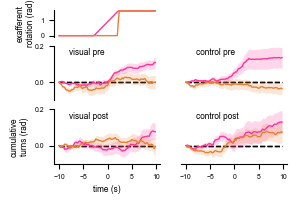

In [48]:
fig, ax = plt.subplots(3, 2, figsize=(3, 2), height_ratios=(1,2,2))

pop_mean_snips = np.asarray([np.nanmean(mean_snips[(vsa==i)*good_rec, ...], axis=0) for i in range(2)])
pop_sem_snips  = np.asarray([np.nanstd(mean_snips[(vsa==i)*good_rec, ...], axis=0)/np.sqrt(np.sum((vsa==i)*good_rec)) for i in range(2)])

# visualize stimulus (once)
for i in range(2):
    ax[0, 0].plot(snip_t, pop_mean_snips[0, 0, i, 2, :], color=color_getter(2*i))

# visualize turning
for i in range(2): # vsa vs non vsa
    for j in range(2): # pre vs post
        for k in range(2): # smooth vs jump
            ax[j+1, i].fill_between(snip_t,
                               pop_mean_snips[i, j, k, 1, :]-pop_sem_snips[i, j, k, 1, :],
                               pop_mean_snips[i, j, k, 1, :]+pop_sem_snips[i, j, k, 1, :],
                               alpha=0.2, color=color_getter(2*k), lw=0)
            ax[j+1, i].plot(snip_t, pop_mean_snips[i, j, k, 1, :], color=color_getter(2*k))
            ax[j+1, i].plot(snip_t, 0*snip_t, 'k--', zorder=-10)
            ax[j+1, i].set_ylim(-0.1, 0.2)

# labels (as titles)    
for i, ab_side in enumerate(('visual', 'control')):
    for j, rec in enumerate(('pre', 'post')):
        ax[j+1, i].text(-8, 0.15, ab_side + ' ' + rec)

# test cumulative behavior & print stats
for k, stim in enumerate(('smooth', 'jump')):
    for j, rec in enumerate(('pre', 'post')):
        ranksum_p = ranksums(mean_snips[vsa==0, j, k, 1, -1],
                             mean_snips[vsa==1, j, k, 1, -1])[1]
        print(rec, stim, 'across groups p={:0.2f}'.format(ranksum_p))

for i, ab_side in enumerate(('visual', 'control')):
    wilcoxon_p = wilcoxon(np.diff(mean_snips[vsa==i, :, 0, 1, -1], axis=1))[1][0]
    print(ab_side, 'smooth pre post p={:0.2f}'.format(wilcoxon_p))
    
ax[0, 0].set_ylabel('exafferent\nrotation (rad)')
ax[-1, 0].set_ylabel('cumulative\nturns (rad)')
ax[-1, 0].set_xlabel('time (s)')

for i in range(3):
    for j in range(2):
        toggle_spines(ax[i, j], 0,i==2,0,j==0)

plt.savefig('../svg/ed01_g.svg')
plt.show()

## Extended Data Fig. 9i (single cell tuning before/after ablation)
- For each cell in each fish for each epoch for each recording, calculate HD tuning
- fit von Mises and get R2

In [50]:
# prepare bins for tuning curves
tuning_bin_edges = np.linspace(-np.pi, np.pi, n_offset_bin+1)
tuning_bin_center = (tuning_bin_edges[:-1] + tuning_bin_edges[1:])/2

In [51]:
# go through recordings and do the binning & von Mises fit
indiv_tuning = []
all_R2 = []
for DD in tqdm(data):
    for rec in (('pre', 'post')):
        D = DD[rec]
        
        indiv_tuning = []
        
        is_jump = D['t']>D['slog'][-1]['t_start']
        if rec == 'pre':
            is_smooth = split_time(D['t'], D['slog'][-2]['t_start'], D['slog'][-2]['duration'], False)
        else:
            is_smooth = (D['t']>D['slog'][-2]['t_start']) * (D['t']<D['slog'][-1]['t_start'])
        
        for y, b in zip(D['traces'], DD['preferred_theta']):
            indiv_tuning.append((
                binned_statistic(angular_diff(D['theta'][is_smooth], b), y[is_smooth], bins=tuning_bin_edges)[0],
                binned_statistic(angular_diff(D['theta'][is_jump], b),  y[is_jump],  bins=tuning_bin_edges)[0]
            ))
        indiv_tuning = np.asarray(indiv_tuning)
        
        # normalization
        indiv_tuning = (indiv_tuning - np.nanmin(indiv_tuning, axis=2)[:, :, None]) /\
                       (np.nanmax(indiv_tuning, axis=2) - np.nanmin(indiv_tuning, axis=2))[:, :, None]
        
        
        fp_smooth, _, r2_smooth = fit_transform_sinusoid(indiv_tuning[:, 0, :], tuning_bin_center)
        fp_jump, _, r2_jump = fit_transform_sinusoid(indiv_tuning[:, 1, :], tuning_bin_center)
        
        # registration
        D['indiv_tuning'] = indiv_tuning
        D['indiv_tuning_fit_param'] = np.asarray((fp_smooth, fp_jump))
        D['indiv_tuning_fit_r2'] = np.asarray((r2_smooth, r2_jump))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:10<00:00,  3.64it/s]


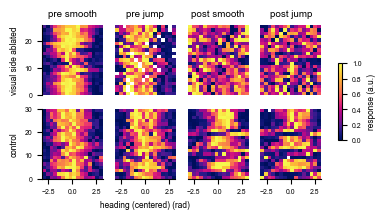

In [52]:
## Visualize example fish (from each group)

fids = (12, 10)
fig, ax = plt.subplots(2, 4, figsize=(4.5, 2))

for i, ff in enumerate(fids):
    for j, rec in enumerate(('pre', 'post')): # pre post
        for k in range(2): # smooth jump
            im = ax[i, 2*j+k].imshow(data[ff][rec]['indiv_tuning'][:, k, :], 
                                     aspect='auto', interpolation='none', vmin=0, vmax=1, cmap=cc.cm.CET_L8,
                                     extent=(-np.pi, np.pi, 0, data[ff]['n_roi']))
            
cb = plt.colorbar(im, ax=ax, location='right', shrink=0.5)
cb.set_label('response (a.u.)')

ax[0,0].set_ylabel('visual side ablated')
ax[1,0].set_ylabel('control')
ax[1,1].set_xlabel('heading (centered) (rad)')

ax[0,0].set_title('pre smooth')
ax[0,1].set_title('pre jump')
ax[0,2].set_title('post smooth')
ax[0,3].set_title('post jump')

for i in range(2):
    for j in range(4):
        toggle_spines(ax[i, j],0,i==1,0,j==0)

plt.savefig('../svg/ed09_i.svg')
plt.show()

## Ectended Data Fig. 9j (von Mises R2 change across recordings, comapred across ablation sides, within each epoch type)

In [53]:
# concatenate all cells from the two groups, and compare pre/post for each epoch

smooth_r2diff = [[], []]
jump_r2diff = [[], []]

for i, D in enumerate(data):
    if good_rec[i]:
        smooth_r2diff[vsa[i]].append(D['post']['indiv_tuning_fit_r2'][0] - D['pre']['indiv_tuning_fit_r2'][0])
        jump_r2diff[vsa[i]].append(D['post']['indiv_tuning_fit_r2'][1] - D['pre']['indiv_tuning_fit_r2'][1])

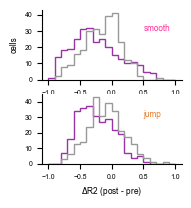

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(1.8, 2))
ax[0].hist([np.hstack(y) for y in smooth_r2diff], color=(color_getter(1), color_getter(8)) , histtype='step', bins=np.linspace(-1,1,21), label=('ctrl.','visual'))
ax[1].hist([np.hstack(y) for y in jump_r2diff], color=(color_getter(1), color_getter(8)) , histtype='step', bins=np.linspace(-1,1,21), label=('ctrl.','visual'))

ax[0].set_ylabel('cells')
ax[1].set_xlabel('$\Delta$R2 (post - pre)')

ax[0].text(0.5, 30, 'smooth', color=color_getter(0))
ax[1].text(0.5, 30, 'jump', color=color_getter(2))

toggle_spines(ax[0], 0, 1, 0, 1)
toggle_spines(ax[1], 0, 1, 0, 1)

plt.savefig('../svg/ed09_j.svg')
plt.show()

## Extended Data Fig. 10b (bump movement around scene rotations in post-visual side ablation recordings)
- Does the visual side ablation spare the angular path integration?
- Ask this with multiple regression of bump phase by motor and exogenous-visual components in the post-ablation recording smooth epochs
- Test the significance of the regression model with bootstrapping

In [56]:
for i, D in enumerate(data):
    
    # find the midpoints of the rotations
    slog = D['post']['slog'][-2] # post ablation epoch -> smooth epoch = second from the last
    
    midpoints = np.arange(slog['t_start']+slog['OLperiod']-slog['OLduration']/2, slog['t_start']+slog['duration']-slog['OLduration'], slog['OLperiod'])
    
    # prepare traces to be worked upon (curtail)
    t = D['post']['t']
    this_epoch = (t>slog['t_start']) * (t<(slog['t_start']+slog['duration']))
    t = t[this_epoch]
    pva = D['post']['pva_theta'][this_epoch]
    mot = D['post']['cumftheta'][this_epoch]
    vis = D['post']['extheta'][this_epoch]
    
    pva_snip, snip_t = cut_snip(np.unwrap(pva), t, midpoints, hw, hw)
    mot_snip, _ = cut_snip(mot, t, midpoints, hw, hw)
    vis_snip, _ = cut_snip(vis, t, midpoints, hw, hw)
    
    ridge_model = Ridge(alpha=1.0, fit_intercept=True, positive=True)
    
    # calculate trial-wise sample coefficients
    coef = []
    r2 = []
    for y, x0, x1 in zip(pva_snip, mot_snip, vis_snip):
        ridge_model.fit(np.vstack((x0, x1)).T, y)
        coef.append(ridge_model.coef_)
        r2.append(ridge_model.score(np.vstack((x0, x1)).T, y))
    coef = np.asarray(coef)
    r2 = np.asarray(r2)
    
    # do bootstrapping
    bs_mean_coef = np.zeros((n_bootstrap, 2))
    bs_mean_r2 = np.zeros(n_bootstrap)
    for b in tqdm(range(n_bootstrap)):
        # roll by a random amount
        shift_amount = np.random.randint(len(t))
        rolled_pva = np.roll(pva, shift_amount)
        rolled_pva_snip, _ = cut_snip(rolled_pva, t, midpoints, hw, hw, subtract_pre=True)

        # need to remove the local period containing the discontinuity due to the shuffling
        discontinuous_point = t[shift_amount]
        is_discontinuous = np.abs(midpoints - discontinuous_point) < hw

        this_bs_coef = []
        this_bs_r2 = []
        for k in range(len(midpoints)):
            if not is_discontinuous[k]:
                regressor = np.vstack((mot_snip[k, :], vis_snip[k, :])).T
                ridge_model.fit(regressor, rolled_pva_snip[k, :])
                this_bs_coef.append(ridge_model.coef_)
                this_bs_r2.append(ridge_model.score(regressor, rolled_pva_snip[k, :]))

        bs_mean_coef[b, :] = np.mean(np.asarray(this_bs_coef), axis=0)
        bs_mean_r2[b] = np.mean(this_bs_r2)
        coef_p = np.mean(bs_mean_coef > np.mean(coef, axis=0)[None, :], axis=0)
        r2_p = np.mean(bs_mean_r2 > np.mean(r2))

    D['post']['coef'] = coef
    D['post']['r2'] = r2
    D['post']['pva_snip'] = pva_snip
    D['post']['mot_snip'] = mot_snip
    D['post']['vis_snip'] = vis_snip
    
    D['post']['mean_coef'] = np.mean(coef, axis=0)
    D['post']['bs_mean_coef'] = bs_mean_coef    
    D['post']['bs_mean_r2'] = bs_mean_r2    
    D['post']['coef_p'] = coef_p    
    D['post']['r2_p'] = r2_p       

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 45.84it/s]


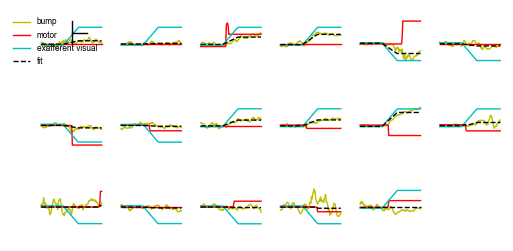

In [57]:
fid = 12 # same example fish
D = data[fid]
fig, ax = plt.subplots(3, 6, figsize=(6,3))
rec = 'post'

vmax = 3
for i in range(len(midpoints)):
    ax[i//6, i%6].plot(snip_t, D[rec]['pva_snip'][i, :], 'y-', label='bump')
    ax[i//6, i%6].plot(snip_t, D[rec]['mot_snip'][i, :], 'r-', label='motor')
    ax[i//6, i%6].plot(snip_t, D[rec]['vis_snip'][i, :], 'c-', label='exafferent visual')
    ax[i//6, i%6].plot(snip_t, D[rec]['mot_snip'][i, :]*D[rec]['coef'][i,0] + D[rec]['vis_snip'][i, :]*D[rec]['coef'][i,1], 'k--', label='fit')
    ax[i//6, i%6].set_ylim(-vmax, vmax)
ax[0,0].legend()
ax[0,0].plot((0,0), (0, 2), 'k-')
ax[0,0].plot((0,5), (1, 1), 'k-')
for axx in ax:
    for axxx in axx:
        toggle_spines(axxx, 0, 0, 0, 0)
        
plt.savefig('../svg/ed10_b.svg')
plt.show()

## Extended Data Fig. 10c,d (Visual vs. motor coefficients + cumulative distribution of bootstrap p-values of R2)

In [58]:
# calculate p-value CDF from good visual side ablated recordings
good_vab_rec = np.where(good_rec * (vsa==1))[0]
mean_coef = np.vstack([D['post']['mean_coef'] for D in data])[good_vab_rec]
r2_p = np.asarray([D['post']['r2_p'] for D in data])[good_vab_rec]
p_x = np.linspace(0,1,1000)
p_cdf = np.asarray([np.mean(r2_p<x) for x in p_x])
ksp = kstest(r2_p, uniform.cdf)[1]

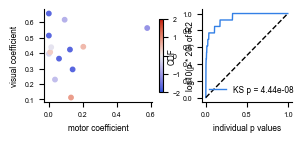

In [59]:
fig, ax = plt.subplots(1,2,figsize=(3.2, 1.2), width_ratios=(3,2))

# motor vs. visual coefficients, labeled with p-values
sc = ax[0].scatter(mean_coef[:, 0],mean_coef[:, 1], c=np.log10(20*(r2_p + 1/n_bootstrap)),
                vmin=-2, vmax=2, s=10, cmap=cc.cm.CET_D1)
cb = plt.colorbar(sc, ax=ax[0], shrink=0.8, location='right')
ax[0].set_xlabel('motor coefficient')
ax[0].set_ylabel('visual coefficient')
cb.set_label('log10(p * 20) of R2')

# p-value CDF with KS test
ax[1].plot(p_x, p_cdf, color=color_getter(3), label='KS p = {:0.2e}'.format(ksp))
ax[1].plot(p_x, p_x, 'k--')
ax[1].legend()
ax[1].set_xlabel('individual p values')
ax[1].set_ylabel('CDF')

toggle_spines(ax[0], 0,1,0,1)
toggle_spines(ax[1], 0,1,0,1)

plt.savefig('../svg/ed10_cd.svg')
plt.show()